In [165]:
import sys
sys.path.append("..")

import time
import pandas as pd
import matplotlib.pyplot as plt

from datasets.custom_dataset import CustomDataset

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale, ToPILImage, ToTensor, Normalize

from sklearn.model_selection import train_test_split

## Carga del set de datos

### Directorios

In [166]:
dataset_path = '../datasets/covid-19-radiography-dataset.csv'
images_path = '../datasets/unfiltered_images'

dataset = pd.read_csv(dataset_path)
dataset_file_names = dataset['file_name']
dataset_labels = dataset['label']

dataset.head()

,file_name,label
0,COVID-1.png,0
1,COVID-10.png,0
2,COVID-100.png,0
3,COVID-1000.png,0
4,COVID-1001.png,0


### Distribución de las clases en el set de datos

In [167]:
class_ids = {
    0: 'covid',
    1: 'lung_opacity',
    2: 'normal',
    3: 'viral_pneumonia'
}

def count_dataset_classes(labels, class_ids):
    class_count = {
        'covid': 0,
        'lung_opacity': 0,
        'normal': 0,
        'viral_pneumonia': 0
    }
    
    for label in labels:
        class_id = class_ids[label]
        class_count[class_id] += 1
    
    return class_count

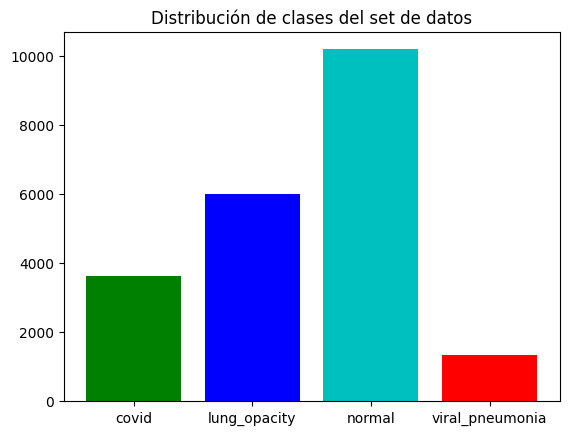

In [168]:
dataset_class_count = count_dataset_classes(dataset_labels, class_ids)

fig, ax = plt.subplots()
ax.set_title('Distribución de clases del set de datos')
ax.bar(list(dataset_class_count.keys()), list(dataset_class_count.values()), color=['g', 'b', 'c', 'r'])

plt.show()

### División del set de datos

Train set distribution:  {'covid': 2893, 'lung_opacity': 4809, 'normal': 8154, 'viral_pneumonia': 1076}
Test set distribution:  {'covid': 723, 'lung_opacity': 1203, 'normal': 2038, 'viral_pneumonia': 269}
Test vs Train distribution:  {'covid': 0.19994469026548672, 'lung_opacity': 0.2000998003992016, 'normal': 0.1999607535321821, 'viral_pneumonia': 0.2}


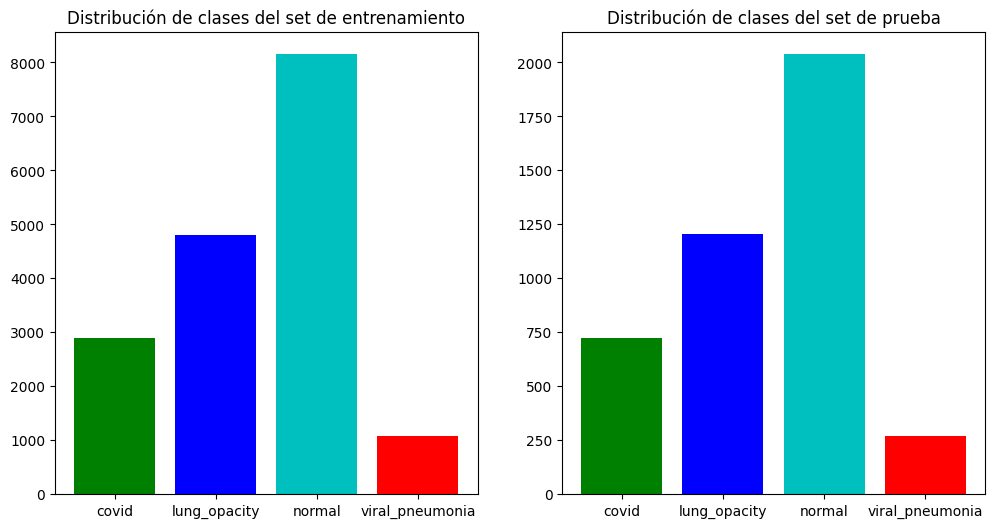

In [169]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset_file_names, dataset_labels, test_size=0.2, random_state=404, stratify=dataset_labels)

train_class_count = count_dataset_classes(y_train, class_ids)
test_class_count = count_dataset_classes(y_test, class_ids)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_title('Distribución de clases del set de entrenamiento')
ax[0].bar(list(train_class_count.keys()), list(train_class_count.values()), color=['g', 'b', 'c', 'r'])

ax[1].set_title('Distribución de clases del set de prueba')
ax[1].bar(list(test_class_count.keys()), list(test_class_count.values()), color=['g', 'b', 'c', 'r'])

print('Train set distribution: ', train_class_count)
print('Test set distribution: ', test_class_count)
print('Test vs Train distribution: ', {k: test_class_count[k] / (dataset_class_count[k]) for k in test_class_count})
plt.show()

## Definicición del modelo


### Uso de GPU si está disponible

In [170]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cpu device


### Arquitectura del modelo

In [171]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Dropout(p=0.3),
            
            nn.Linear(in_features=88209, out_features=4),
            nn.ReLU(),
            
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            # nn.ReLU(),
            
            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),

            # nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            # nn.ReLU(),
            
            # nn.Flatten(),
            # nn.Dropout(p=0.3),
            
            # nn.Linear(in_features=1600, out_features=4096),
            # nn.ReLU(),
            
            # nn.Linear(in_features=4096, out_features=40),
            # nn.ReLU(),
        )

    def forward(self, x):
        logits = self.sequential(x)
        return logits

## Entrenamiento del modelo

### Definición de métricas

In [172]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision
from torchmetrics.classification import MulticlassRecall
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassROC
from torchmetrics.classification import MulticlassAUROC

train_accuracy = MulticlassAccuracy(num_classes=4).to(device)
test_accuracy = MulticlassAccuracy(num_classes=4).to(device)

train_precision = MulticlassPrecision(num_classes=4).to(device)
test_precision = MulticlassPrecision(num_classes=4).to(device)

train_recall = MulticlassRecall(num_classes=4).to(device)
test_recall = MulticlassRecall(num_classes=4).to(device)

train_f1 = MulticlassF1Score(num_classes=4).to(device)
test_f1 = MulticlassF1Score(num_classes=4).to(device)

train_roc = MulticlassROC(num_classes=4).to(device)
test_roc = MulticlassROC(num_classes=4).to(device)

train_auroc = MulticlassAUROC(num_classes=4).to(device)
test_auroc = MulticlassAUROC(num_classes=4).to(device)

### Función de entrenamiento

In [173]:
def train(dataloader, model, loss_fn, optimizer):
    print('--------------------------- Training --------------------------\n')
    size = len(dataloader.dataset)
    loss = torch.Tensor([0]).to(device)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        
        train_accuracy.update(pred, y)
        train_precision.update(pred, y)
        train_recall.update(pred, y)
        train_f1.update(pred, y)    
        train_roc.update(pred, y)
        train_auroc.update(pred, y)
        
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f'Current Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')
    
    return loss.item()

### Función de evaluación

In [174]:
def test(dataloader, model, loss_fn):
    print('--------------------------- Testing ---------------------------\n')
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            
            test_accuracy.update(pred, y)
            test_precision.update(pred, y)
            test_recall.update(pred, y)
            test_f1.update(pred, y)    
            test_roc.update(pred, y)
            test_auroc.update(pred, y)
            
            test_loss += loss_fn(pred, y).item()
            
    test_loss /= num_batches
    print(f'Test Error: \n Accuracy: {(100*test_accuracy.compute().item()):>0.1f}%, Avg loss: {test_loss:>8f} \n')
    return test_loss

### Ciclo de entrenamiento

In [175]:
batch_size = 32
learning_rate = 1e-5
epochs = 3

train_dataset = CustomDataset(images_path, X_train, y_train, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

test_dataset = CustomDataset(images_path, X_test, y_test, transform=Compose([
    Grayscale(),
    ToPILImage(),
    ToTensor(),
    Normalize(0.5, 0.5)
]))

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

model = ConvolutionalNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)

In [176]:
train_metrics = []
test_metrics = []

start_time = time.time()
for epoch in range(epochs):
    print(f'--------------------------- Epoch {epoch+1} ---------------------------\n')
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)
    
    train_metrics.append({'loss': train_loss,
                          'accuracy': train_accuracy.compute().item(),
                          'precision': train_precision.compute().item(), 
                          'recall': train_recall.compute().item(),
                          'f1': train_f1.compute().item(),
                          'roc': train_roc.compute(),
                          'auroc': train_auroc.compute().item()})
    
    test_metrics.append({'loss': test_loss,
                         'accuracy': test_accuracy.compute().item(),
                         'precision': test_precision.compute().item(),
                         'recall': test_recall.compute().item(),
                         'f1': test_f1.compute().item(),
                         'roc': test_roc.compute(),
                         'auroc': test_auroc.compute().item()})
    
    train_accuracy.reset()
    train_precision.reset()
    train_recall.reset()
    train_f1.reset()
    train_roc.reset()
    train_auroc.reset()
    
    test_accuracy.reset()
    test_precision.reset()
    test_recall.reset()
    test_f1.reset()
    test_roc.reset()
    test_auroc.reset()

end_time = time.time()
print(f'Training time: {(end_time - start_time)/60:>0.3f} minutes')

--------------------------- Epoch 1 ---------------------------

--------------------------- Training --------------------------

Current Loss: 1.517540  [   32/16932]
Current Loss: 1.444997  [  352/16932]
Current Loss: 1.284975  [  672/16932]
Current Loss: 1.168080  [  992/16932]
Current Loss: 1.250737  [ 1312/16932]
Current Loss: 1.278244  [ 1632/16932]
Current Loss: 1.228733  [ 1952/16932]
Current Loss: 1.203103  [ 2272/16932]
Current Loss: 1.371165  [ 2592/16932]
Current Loss: 1.159076  [ 2912/16932]
Current Loss: 1.203568  [ 3232/16932]
Current Loss: 1.102943  [ 3552/16932]
Current Loss: 1.047757  [ 3872/16932]
Current Loss: 1.004626  [ 4192/16932]
Current Loss: 1.111002  [ 4512/16932]
Current Loss: 1.008458  [ 4832/16932]
Current Loss: 1.034420  [ 5152/16932]
Current Loss: 1.121243  [ 5472/16932]
Current Loss: 1.122632  [ 5792/16932]
Current Loss: 1.171057  [ 6112/16932]
Current Loss: 0.989455  [ 6432/16932]
Current Loss: 1.115222  [ 6752/16932]
Current Loss: 0.964272  [ 7072/169

## Evaluación del modelo

### Curva de entrenamiento

/tmp/ipykernel_3586/2750665807.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


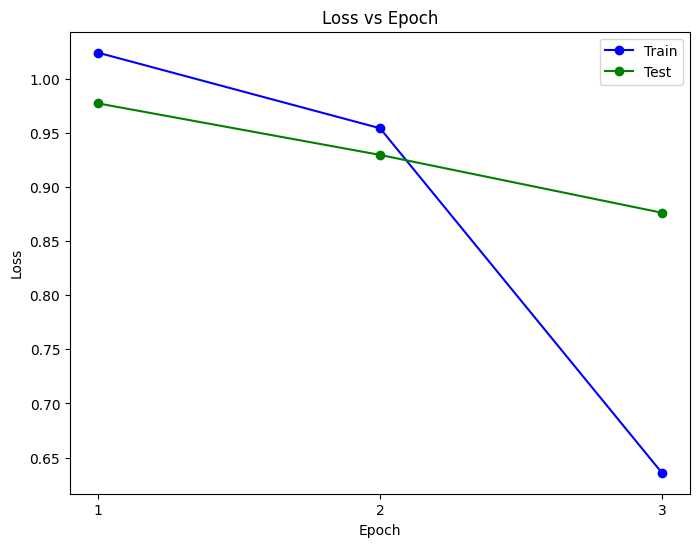

In [177]:
epoch_list = [(epoch_num+1) for epoch_num in range(epochs)]
train_losses = [train_metrics[i]['loss'] for i in range(epochs)]
test_losses = [test_metrics[i]['loss'] for i in range(epochs)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Loss vs Epoch')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_xticks(epoch_list)

ax.plot(epoch_list, train_losses, label='Train', color='b', marker='o')
ax.plot(epoch_list, test_losses, label='Test', color='g', marker='o')

ax.legend()
fig.show()

### Métricas del modelo

/tmp/ipykernel_3586/3218451957.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


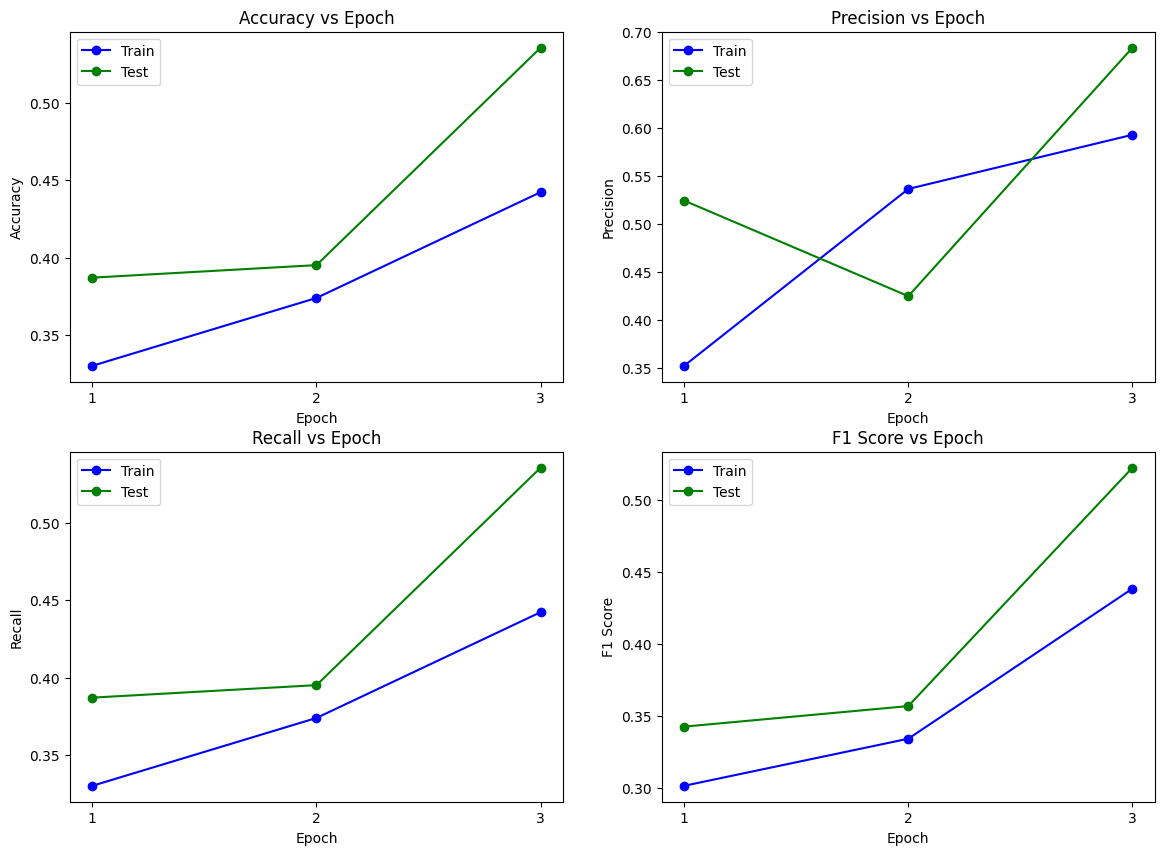

In [178]:
train_accuracies = [train_metrics[i]['accuracy'] for i in range(epochs)]
test_accuracies = [test_metrics[i]['accuracy'] for i in range(epochs)]

train_precisions = [train_metrics[i]['precision'] for i in range(epochs)]
test_precisions = [test_metrics[i]['precision'] for i in range(epochs)]

train_recalls = [train_metrics[i]['recall'] for i in range(epochs)]
test_recalls = [test_metrics[i]['recall'] for i in range(epochs)]

train_f1_scores = [train_metrics[i]['f1'] for i in range(epochs)]
test_f1_scores = [test_metrics[i]['f1'] for i in range(epochs)]

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0, 0].set_title('Accuracy vs Epoch')
ax[0, 0].set_ylabel('Accuracy')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_xticks(epoch_list)


ax[0, 1].set_title('Precision vs Epoch')
ax[0, 1].set_ylabel('Precision')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_xticks(epoch_list)

ax[1, 0].set_title('Recall vs Epoch')
ax[1, 0].set_ylabel('Recall')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_xticks(epoch_list)

ax[1, 1].set_title('F1 Score vs Epoch')
ax[1, 1].set_ylabel('F1 Score')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_xticks(epoch_list)

ax[0, 0].plot(epoch_list, train_accuracies, label='Train', color='b', marker='o')
ax[0, 0].plot(epoch_list, test_accuracies, label='Test', color='g', marker='o')

ax[0, 1].plot(epoch_list, train_precisions, label='Train', color='b', marker='o')
ax[0, 1].plot(epoch_list, test_precisions, label='Test', color='g', marker='o')

ax[1, 0].plot(epoch_list, train_recalls, label='Train', color='b', marker='o')
ax[1, 0].plot(epoch_list, test_recalls, label='Test', color='g', marker='o')

ax[1, 1].plot(epoch_list, train_f1_scores, label='Train', color='b', marker='o')
ax[1, 1].plot(epoch_list, test_f1_scores, label='Test', color='g', marker='o')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
fig.show()

### Gráfico ROC para cada clase

/tmp/ipykernel_3586/1636366242.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


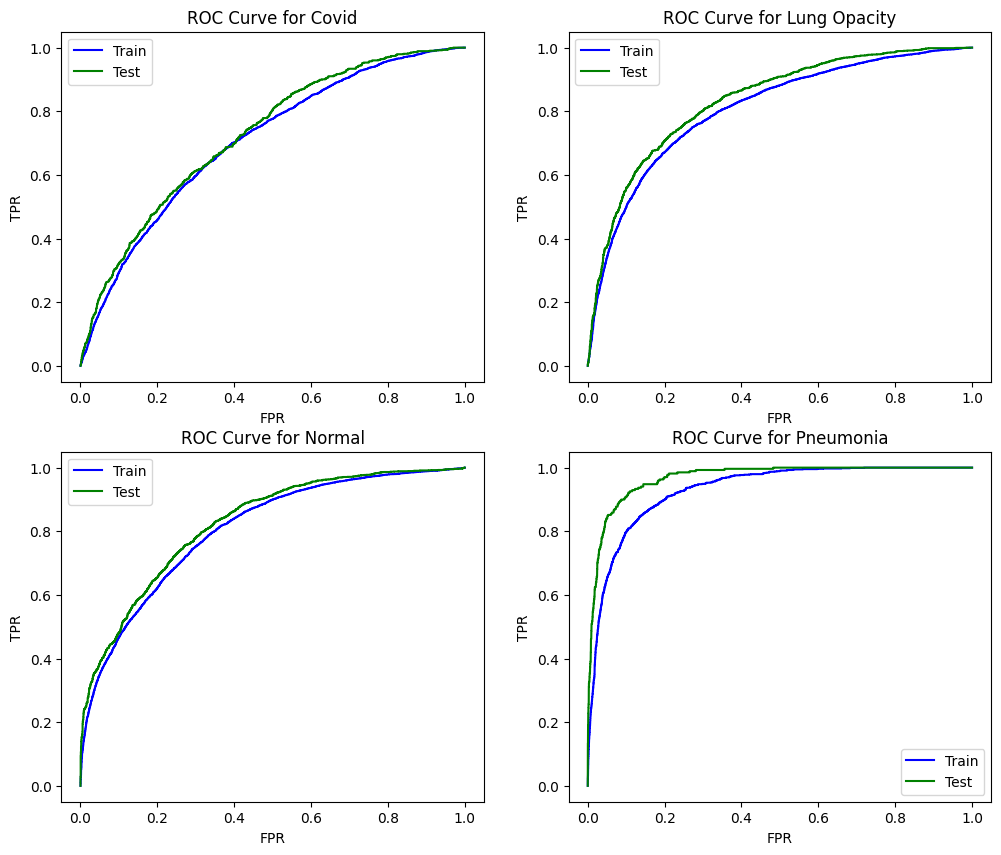

In [179]:
train_roc_fpr = train_metrics[-1]['roc'][0]
train_roc_tpr = train_metrics[-1]['roc'][1]

test_roc_fpr = test_metrics[-1]['roc'][0]
test_roc_tpr = test_metrics[-1]['roc'][1]

fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].set_title('ROC Curve for Covid')
ax[0, 0].set_ylabel('TPR')
ax[0, 0].set_xlabel('FPR')

ax[0, 1].set_title('ROC Curve for Lung Opacity')
ax[0, 1].set_ylabel('TPR')
ax[0, 1].set_xlabel('FPR')

ax[1, 0].set_title('ROC Curve for Normal')
ax[1, 0].set_ylabel('TPR')
ax[1, 0].set_xlabel('FPR')

ax[1, 1].set_title('ROC Curve for Pneumonia')
ax[1, 1].set_ylabel('TPR')
ax[1, 1].set_xlabel('FPR')

ax[0, 0].plot(train_roc_fpr[0], train_roc_tpr[0], label='Train', color='b')
ax[0, 0].plot(test_roc_fpr[0], test_roc_tpr[0], label='Test', color='g')

ax[0, 1].plot(train_roc_fpr[1], train_roc_tpr[1], label='Train', color='b')
ax[0, 1].plot(test_roc_fpr[1], test_roc_tpr[1], label='Test', color='g')

ax[1, 0].plot(train_roc_fpr[2], train_roc_tpr[2], label='Train', color='b')
ax[1, 0].plot(test_roc_fpr[2], test_roc_tpr[2], label='Test', color='g')

ax[1, 1].plot(train_roc_fpr[3], train_roc_tpr[3], label='Train', color='b')
ax[1, 1].plot(test_roc_fpr[3], test_roc_tpr[3], label='Test', color='g')

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()
fig.show()